In [37]:
import pandas as pd
import numpy as np
import regex as re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, fbeta_score, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, precision_recall_curve



def get_test_athletes(dfday):
    athletes = sorted(list(dfday['Athlete ID'].unique()))
    test_athletes = athletes[len(athletes) - 10:] 
    return test_athletes

def normalize2(row, mean_df, std_df, athlete_id):
    mu = mean_df.loc[athlete_id]
    su = std_df.loc[athlete_id]
    z = (row - mu)/su
    return z

# Calculate the means and standard deviations of all healthy events per athlete
def getMeanStd(data):
    mean = data[data['injury'] == 0].groupby('Athlete ID').mean()
    std = data[data['injury'] == 0].groupby('Athlete ID').std()
    std.replace(to_replace=0.0, value=0.01, inplace=True)
    return mean, std

def getBalancedSubset(X_train, samplesPerClass):
    healthySet   = pd.DataFrame()
    unhealthySet = pd.DataFrame()
    

    stats = pd.DataFrame(X_train[['Athlete ID','injury']].groupby(['Athlete ID','injury']).size().reset_index(name='counts'))
    stats = pd.DataFrame(stats[['Athlete ID']].groupby(['Athlete ID']).size().reset_index(name='counts'))
    stats.drop(stats[stats['counts'] < 2].index, inplace=True)
    athleteList = stats['Athlete ID'].unique()

    samplesPerAthlete = int(np.floor(samplesPerClass) / len(athleteList))

    for athlete in athleteList:
        if unhealthySet.empty:
            unhealthySet = X_train[(X_train['Athlete ID'] == athlete) & (X_train['injury'] == 0)].sample(samplesPerAthlete, replace=True)
        else:
            unhealthySet = pd.concat([unhealthySet, X_train[(X_train['Athlete ID'] == athlete) & (X_train['injury'] == 0)].sample(samplesPerAthlete,replace=True)], ignore_index=True)
        if healthySet.empty:
            healthySet = X_train[(X_train['Athlete ID'] == athlete) & (X_train['injury'] == 1)].sample(samplesPerAthlete, replace=True)
        else:
            healthySet = pd.concat([healthySet, X_train[(X_train['Athlete ID'] == athlete) & (X_train['injury'] == 1)].sample(samplesPerAthlete,replace=True)], ignore_index=True)


    balancedSet = pd.concat([healthySet, unhealthySet], ignore_index=True)
    return balancedSet

def training_eval(model, y_true, X, y_pred):
    conf_matrix = confusion_matrix(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    fbeta = fbeta_score(y_true, y_pred, beta=2)  # Emphasize recall

    # Print evaluation metrics
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall(most important): {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"F-beta Score (beta=2): {fbeta:.4f}")

    # Plot confusion matrix
    plt.figure(figsize=(4,3))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 16})
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    # Plot precision-recall curve
    precision_curve, recall_curve, thresholds = precision_recall_curve(y_true, model.predict_proba(X)[:, 1])
    plt.figure(figsize=(4,3))
    plt.plot(recall_curve, precision_curve, label='Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.show()

    # print ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_true, model.predict_proba(X)[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(4,3))
    plt.plot(fpr, tpr, label='ROC Curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend()
    plt.show()

def prepare_balanced_data(df,test_athletes, sample_multiplier=1):

    X_test_original = df[df['Athlete ID'].isin(test_athletes)].copy() # Keep a copy for normalization
    X_train_original = df[~df['Athlete ID'].isin(test_athletes)].copy() # Keep a copy

    X_train_means, X_train_std = getMeanStd(X_train_original)
    X_test_means, X_test_std = getMeanStd(X_test_original)
    X_train_balanced = getBalancedSubset(X_train_original.copy(), (2048*sample_multiplier))
    
    # Set target variable for testing and training
    y_train = X_train_balanced['injury']
    y_test = X_test_original['injury']

    # Apply normalization to the balanced training data
    X_train_norm = X_train_balanced.apply(lambda x: normalize2(x, X_train_means, X_train_std, x['Athlete ID']), axis=1)
    X_train_norm = X_train_norm.drop(columns=['injury', 'Date', 'Athlete ID'], errors='ignore')

    # Apply normalization to the test data using the testing statistics
    # Note this is a source of data leakage! but the alternative is not feasible
    X_test_norm = X_test_original.apply(lambda x: normalize2(x, X_test_means, X_test_std, x['Athlete ID']), axis=1)
    X_test_norm = X_test_norm.drop(columns=['injury', 'Date', 'Athlete ID'], errors='ignore')


    return y_train, y_test, X_train_norm, X_test_norm




## MAIN

Accuracy: 0.6790
Precision: 0.0275
Recall(most important): 0.5400
F1 Score: 0.0524
F-beta Score (beta=2): 0.1143


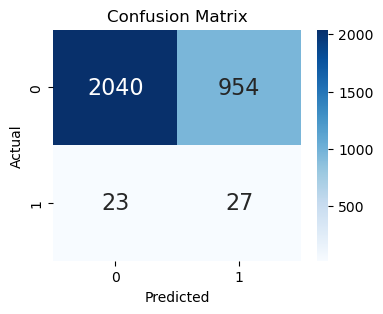

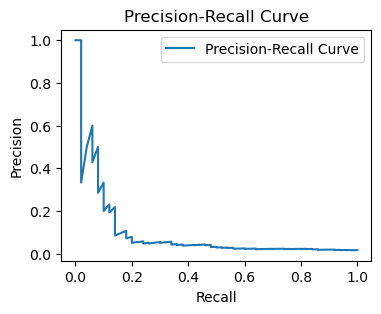

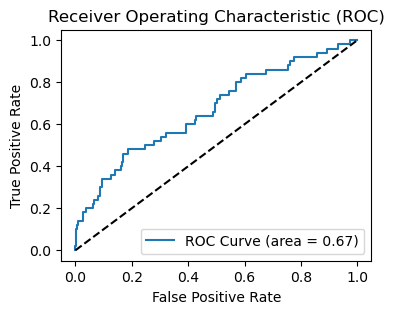

Accuracy: 0.6457
Precision: 0.6605
Recall(most important): 0.5995
F1 Score: 0.6285
F-beta Score (beta=2): 0.6108


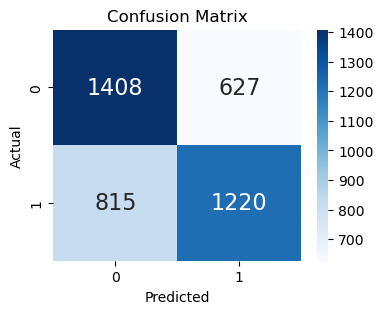

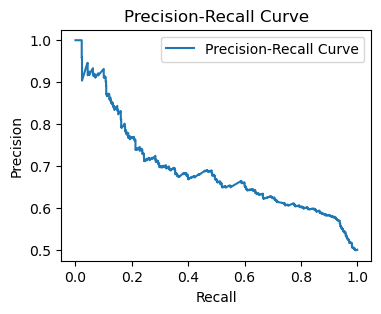

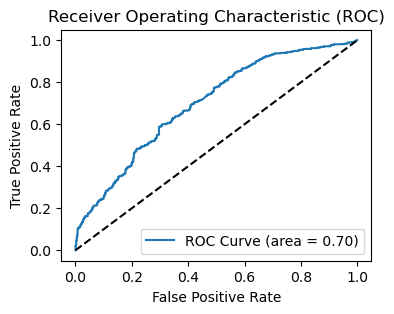

In [38]:
# Load and clean
dfday = pd.read_csv('../data/raw/day_approach.csv')
dfday.drop(list(dfday.filter(regex = 'perceived|sprinting|strength')), axis = 1, inplace = True)

test_athletes = get_test_athletes(dfday) # Get the test athletes


# Prepare the balanced data
y_train, y_test, X_train_norm, X_test_norm = prepare_balanced_data(dfday, test_athletes, sample_multiplier=1)
# 5. Train the Logistic Regression model on the normalized training data
logReg = LogisticRegression()
logReg.fit(X_train_norm, y_train)

# 6. Make predictions on the normalized test data
predictions = logReg.predict(X_test_norm)


# 7. Evaluate the model (as you have done)
training_eval(logReg, y_test, X_test_norm, predictions)
training_eval(logReg, y_train, X_train_norm, logReg.predict(X_train_norm))

## With Bagging

In [48]:
def training_eval_bag(y_true, y_pred):
    conf_matrix = confusion_matrix(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    fbeta = fbeta_score(y_true, y_pred, beta=2)  # Emphasize recall

    # Print evaluation metrics
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall(most important): {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"F-beta Score (beta=2): {fbeta:.4f}")

    # Plot confusion matrix
    plt.figure(figsize=(4,3))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 16})
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')

In [56]:

def apply_bagging(model, X_train, y_train, X_test, y_test, n_bags=10):
    """
    Applies a bagging (bootstrap aggregating) approach to a logistic regression model.

    Args:
        model: The logistic regression model to use.
        X_train (pd.DataFrame): The training feature data.
        y_train (pd.Series): The target variable of the training data.
        X_test (pd.DataFrame): The testing feature data.
        y_test (pd.Series): The target variable of the testing data.
        n_bags (int): The number of bags (models) to create.

    Returns:
        List of predictions from each bag.
    """
    predictions = []
    probabilities = []
    for i in range(n_bags):
        # 1. Create a bootstrap sample
        sample_indices = np.random.choice(len(X_train), len(X_train), replace=True)
        X_sample = X_train.iloc[sample_indices]
        y_sample = y_train.iloc[sample_indices]

        # 2. Train a model on the bootstrap sample
        bag_model = LogisticRegression()
        bag_model.fit(X_sample, y_sample)

        # 3. Make predictions on the test set
        bag_predictions = bag_model.predict(X_test)
        predictions.append(bag_predictions)

            # 4. Store predicted probabilities
        bag_probabilities = bag_model.predict_proba(X_test)[:, 1]  # Probability of class 1
        probabilities.append(bag_probabilities)

    return predictions, probabilities

def combine_predictions(predictions):
  # Convert predictions to a numpy array for easier handling
  predictions_array = np.array(predictions)

  # Compute the mode along the axis 0 (i.e., for each data point)
  from scipy import stats
  mode_results = stats.mode(predictions_array, axis=0)

  # The mode_results object contains the mode and the count. We only need the mode.
  final_predictions = mode_results[0].flatten()  # Flatten to handle multi-dimensional arrays

  return final_predictions

def combine_probabilities(probabilities):
    return np.mean(probabilities, axis=0)


apply the cross validation from the other file (1_cell)

In [ ]:
def eval(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    
    # Print evaluation metrics
    #fpr, tpr, thresholds = roc_curve(y_true, model.predict_proba(X)[:, 1])
    #roc_auc = auc(fpr, tpr)
    #print(f"ROC AUC: {roc_auc:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Recall(most important): {recall:.4f}")


    return (accuracy,recall)

def run_exps(df,test_set, n =5):
    all_results = []
    for i in range(n):
        y_train, y_test, X_train, X_test = prepare_balanced_data(df, test_set)
        #model = train_model(X_train, y_train)

        n_bags = 10  # Number of bags
        bag_predictions, bag_probabilities = apply_bagging(LogisticRegression(), X_train, y_train, X_test, y_test, n_bags=n_bags)

        # Combine the predictions from each bag (e.g., using majority voting)
        final_predictions = combine_predictions(bag_predictions)
        final_probabilities = combine_probabilities(bag_probabilities)
        #y_pred = model.predict(X_test)
        

        from sklearn.metrics import roc_auc_score
        auc = roc_auc_score(y_test, final_probabilities)
        all_results.append(auc)
        print(f"AUC: {auc:.4f}")
        results = eval(y_test, final_predictions)
        all_results.append(results)
    _ =[print(i) for i in all_results]
    print("Mean Accuracy: ", np.mean([x[0] for x in all_results]))
    print("Mean Recall: ", np.mean([x[1] for x in all_results]))
    #print("Mean ROC AUC: ", np.mean([x[2] for x in all_results]))

    
    
def main():

    dfday = pd.read_csv('C:/Users/milo/Desktop/publicprojectsMilo/RunningVolume_Injury/data/raw/day_approach.csv')
    dfday.drop(list(dfday.filter(regex = 'perceived|sprinting|strength')), axis = 1, inplace = True)
    athletes = sorted(list(dfday['Athlete ID'].unique()))
    test_athletes = athletes[len(athletes) - 10:]
    run_exps(dfday, test_athletes, n = 5)


main()

C:\Users\milo\AppData\Local\Temp\ipykernel_36032\3929858716.py:44: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode_results = stats.mode(predictions_array, axis=0)


AUC: 0.6547
Accuracy: 0.6840
Recall(most important): 0.5200


C:\Users\milo\AppData\Local\Temp\ipykernel_36032\3929858716.py:44: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode_results = stats.mode(predictions_array, axis=0)


AUC: 0.6695
Accuracy: 0.6889
Recall(most important): 0.5600


C:\Users\milo\AppData\Local\Temp\ipykernel_36032\3929858716.py:44: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode_results = stats.mode(predictions_array, axis=0)


AUC: 0.6622
Accuracy: 0.7060
Recall(most important): 0.5400


C:\Users\milo\AppData\Local\Temp\ipykernel_36032\3929858716.py:44: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode_results = stats.mode(predictions_array, axis=0)


AUC: 0.6792
Accuracy: 0.6994
Recall(most important): 0.5400
AUC: 0.6612
Accuracy: 0.6942
Recall(most important): 0.5000
(0.6839684625492772, 0.52)
(0.6888961892247043, 0.56)
(0.7059789750328516, 0.54)
(0.6994086727989488, 0.54)
(0.6941524310118266, 0.5)
Mean Accuracy:  0.6944809461235217
Mean Recall:  0.532


C:\Users\milo\AppData\Local\Temp\ipykernel_36032\3929858716.py:44: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode_results = stats.mode(predictions_array, axis=0)


IndexError: tuple index out of range

C:\Users\milo\AppData\Local\Temp\ipykernel_36032\3929858716.py:44: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode_results = stats.mode(predictions_array, axis=0)


Accuracy: 0.6781
Precision: 0.0274
Recall(most important): 0.5400
F1 Score: 0.0522
F-beta Score (beta=2): 0.1140
AUC: 0.6564


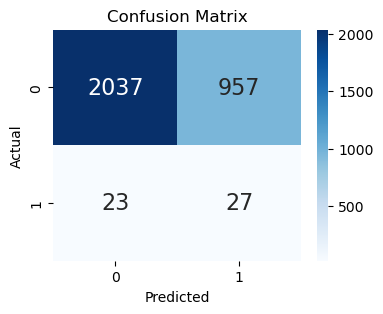

In [55]:
y_train, y_test, X_train_norm, X_test_norm = prepare_balanced_data(dfday, test_athletes, sample_multiplier=1)

# Apply bagging
n_bags = 10  # Number of bags
bag_predictions, bag_probabilities = apply_bagging(LogisticRegression(), X_train_norm, y_train, X_test_norm, y_test, n_bags=n_bags)

# Combine the predictions from each bag (e.g., using majority voting)
final_predictions = combine_predictions(bag_predictions)
final_probabilities = combine_probabilities(bag_probabilities)
# Evaluate the bagged model
training_eval_bag(y_test, final_predictions)

from sklearn.metrics import roc_auc_score
auc = roc_auc_score(y_test, final_probabilities)
print(f"AUC: {auc:.4f}")

## Applying balancing subsets within each bag

In [17]:
def prepare_unbalanced(df, test_athletes):
    X_test_original = df[df['Athlete ID'].isin(test_athletes)].copy()  # Keep a copy for normalization
    X_train_original = df[~df['Athlete ID'].isin(test_athletes)].copy()  # Keep a copy

    X_test_means, X_test_std = getMeanStd(X_test_original)

    # Set target variable for testing
    y_test = X_test_original['injury']

    # Apply normalization to the test data using the testing statistics
    # Note this is a source of data leakage! but the alternative is not feasible
    X_test_norm = X_test_original.apply(lambda x: normalize2(x, X_test_means, X_test_std, x['Athlete ID']), axis=1)
    X_test_norm = X_test_norm.drop(columns=['injury', 'Date', 'Athlete ID'], errors='ignore')

    return X_train_original, y_test, X_test_norm

In [45]:
def train_model(X_train, y_train):
    """
    Train a logistic regression model on the training data.

    Args:
        X_train (pd.DataFrame): The training feature data.
        y_train (pd.Series): The target variable of the training data.

    Returns:
        LogisticRegression: The trained logistic regression model.
    """

    # model = LogisticRegression()
    from xgboost import XGBClassifier
    model = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=1)
    model.fit(X_train, y_train)
    return model

In [46]:
def apply_bagging_different_subsets(X_train_original, y_test, X_test_norm, n_bags=10, sample_multiplier=1):
    """
    Applies a bagging (bootstrap aggregating) approach to a logistic regression model,
    creating a new balanced subset for each bag.

    Args:
        X_train_original (pd.DataFrame): The original training feature data (before balancing).
        y_test (pd.Series): The target variable of the testing data.
        X_test_norm (pd.DataFrame): The normalized testing feature data.
        n_bags (int): The number of bags (models) to create.
        sample_multiplier (int): multiplier for the balanced subset

    Returns:
        A numpy array of combined predictions (mode of predictions).
    """
    predictions = np.zeros((len(X_test_norm), n_bags))  # Store predictions from each bag
    probabilities = np.zeros((len(X_test_norm), n_bags)) # Store probabilities
    model_weights = np.zeros(n_bags)
    model_weights = np.zeros(n_bags)

    for i in range(n_bags):
        # 1. Create a balanced subset for this bag
        X_train_balanced = getBalancedSubset(X_train_original.copy(), (2048 * sample_multiplier))

        # 2. Set target variable for training
        y_train = X_train_balanced['injury']

        # 3. Apply normalization to the balanced training data
        X_train_means, X_train_std = getMeanStd(X_train_balanced)
        X_train_norm = X_train_balanced.apply(lambda x: normalize2(x, X_train_means, X_train_std, x['Athlete ID']), axis=1)
        X_train_norm = X_train_norm.drop(columns=['injury', 'Date', 'Athlete ID'], errors='ignore')

        # 4. Train a model on the balanced and normalized training data
        bag_model = train_model(X_train_norm, y_train) 
        

        # 5. Make predictions on the test set
        predictions[:, i] = bag_model.predict(X_test_norm)

     # 6. Calculate recall on the training data
        y_train_pred = bag_model.predict(X_train_norm)
        model_weights[i] = recall_score(y_train, y_train_pred)

    # Combine predictions using weighted voting
    weighted_predictions = np.zeros(len(X_test_norm))
    for i in range(len(X_test_norm)):
        # Calculate weighted votes for each class
        class_0_weight = np.sum(model_weights[predictions[i, :] == 0])
        class_1_weight = np.sum(model_weights[predictions[i, :] == 1])

        # Predict the class with the higher weighted vote
        if class_1_weight >= class_0_weight:
            weighted_predictions[i] = 1
        else:
            weighted_predictions[i] = 0

    # Combine probabilities using weighted averaging
    weighted_probabilities = np.zeros(len(X_test_norm))
    for i in range(len(X_test_norm)):
        # Calculate weighted probabilities for each class
        weighted_probabilities[i] = np.average(probabilities[i, :], weights=model_weights)


    return weighted_predictions, weighted_probabilities

Accuracy: 0.8844
Precision: 0.0424
Recall(most important): 0.2800
F1 Score: 0.0737
F-beta Score (beta=2): 0.1321
AUC: 0.5000
AUC2: 0.5000


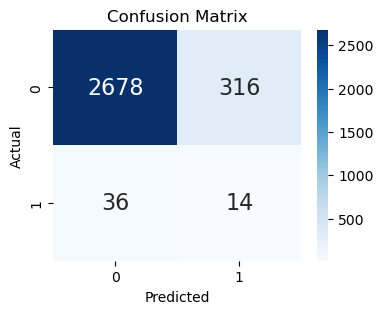

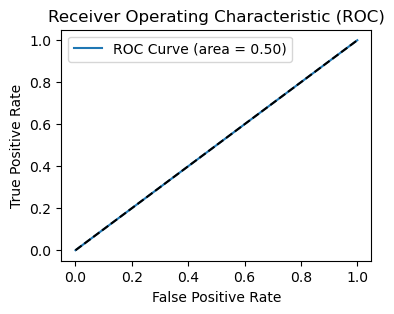

In [47]:
X_train, y_test, X_test_norm = prepare_unbalanced(dfday, test_athletes)

# Apply bagging
n_bags = 10  # Number of bags

final_predictions,final_probabilities = apply_bagging_different_subsets(X_train, y_test, X_test_norm, n_bags=n_bags, sample_multiplier=1)
 

# Evaluate the bagged model
training_eval_bag(y_test, final_predictions)

from sklearn.metrics import roc_auc_score, roc_curve, auc
roc_auc = roc_auc_score(y_test, final_probabilities)
print(f"AUC: {roc_auc:.4f}")

fpr, tpr, thresholds = roc_curve(y_test, final_probabilities)
roc_auc = auc(fpr, tpr)
print(f"AUC2: {roc_auc:.4f}")
plt.figure(figsize=(4,3))
plt.plot(fpr, tpr, label='ROC Curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend()
plt.show()